# Plot temperature response over time

This notebook plots temperature respons to SLCFs AND the total scenario forcing in a fixed nr of years

## Imports:

In [59]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic

In [61]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

# PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
# PATH_DT = OUTPUT_DATA_DIR / '/dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP.nc'

## Set values:

In [62]:
first_y = '1750'
last_y = '2100'
# Years to plot:
years = ['2040', '2100']

**Set reference year for temperature change:**

In [63]:
ref_year = '2021'

In [64]:
FIGURE_DIR = RESULTS_DIR / 'figures/'

In [65]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

In [66]:

name_deltaT = 'Delta T'

### Define variables to look at:

In [67]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-total',
    'o3',
    'HFCs',
    'bc_on_snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:

In [68]:

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip', 'ssp370-lowNTCF-gidden'  # Due to mistake here
                    ]

### Scenarios:

In [69]:
scenarios_fl = ['ssp119',
                'ssp126',
                'ssp245',
                'ssp370',
                'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                'ssp585']

In [70]:
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'

In [71]:

variables_tot = ['Total']
variables_sum = ['Sum SLCFs']


def setup_table_prop(scenario_n='', yrs=None, _vlist=None, scens=None):
    if _vlist is None:
        _vlist = variables_erf_comp
    if yrs is None:
        yrs = ['2040', '2100']
    if scens is None:
        scens = scenarios_fl
    its = [yrs, _vlist]
    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scens, index=_i)  # .transpose()
    table.index.name = scenario_n
    return table

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [72]:
ds_DT = xr.open_dataset(PATH_DT)

## Compute sum of all SLCF forcers

In [73]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

In [74]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, get_scenario_ls_dic

In [75]:

s_y = first_y

cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()


def sum_name(_var):
    """
    Returns the name off the sum o
    """
    return f'{_var} sum '


# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT['ERF'].sel(variable=var))
    _lst_dt.append(ds_DT[name_deltaT].sel(variable=var))
# Name of new var:
erf_all = sum_name('ERF')
# Name of new var:
dt_all = sum_name(name_deltaT)
# ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
# ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

### compute sum: 

In [76]:
sum_name = 'Sum SLCFs'
ds_sub = ds_DT.sel(variable=variables_erf_comp)
ds_sum = ds_sub.sum(variable)
ds_sum = ds_sum.assign_coords(coords={variable: sum_name})
# add sum to variable coordinate

ds_sum = xr.concat([ds_sum, ds_DT.sel(variable=variables_erf_comp)], dim=variable)

In [77]:
ds_sum  # .assign_coords(coords={variable:sum_name})

<xarray.Dataset>
Dimensions:     (percentile: 3, scenario: 10, variable: 6, year: 351)
Coordinates:
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'
  * year        (year) int64 1750 1751 1752 1753 1754 ... 2097 2098 2099 2100
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-aerchemmip'
  * variable    (variable) object 'Sum SLCFs' 'ch4' ... 'HFCs' 'bc_on_snow'
Data variables:
    time        (year) datetime64[ns] ...
    ERF         (scenario, year, variable) float64 0.0 0.0 ... 0.2122 0.02698
    delta_t     (variable, year) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Delta T     (percentile, scenario, year, variable) float64 0.0 ... 0.02896

In [78]:
scntab_dic = {}


# tab_tot = setup_table2()
# tab_tot_sd = setup_table2()
def table_of_sts(_ds, _scn_fl, variables, tab_vars, _yrs, ref_yr, sts='median'):
    """
    Creates pandas dataframe of statistics (mean, median, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios,

    :param _ds:
    :param _scn_fl:
    :param variables:
    :param tab_vars:
    :param _yrs:
    :param ref_yr:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(yrs=_yrs, _vlist=tab_vars)
    for scn in _scn_fl:
        for _var, tabvar in zip(variables, tab_vars):
            # dtvar =  name_deltaT # if ERF name, changes it here.
            tabscn = scn  # Table scenario name the same.
            for year in _yrs:
                _da = _ds[name_deltaT].sel(scenario=scn, variable=_var)
                _da_refy = _da.sel(year=slice(ref_yr, ref_yr)).squeeze()  # ref year value
                _da_y = _da.sel(year=slice(year, year))  # year value
                _tab_da = _da_y - _da_refy
                tabel.loc[(year, tabvar), tabscn] = float(_tab_da.sel(percentile=sts).squeeze().values)  # [0]

    return tabel


def table_of_stats_varsums(_ds, dsvar, tabvar, yrs, ref_yr, sts='median'):
    """
    Sums up over dimension 'variable' and creates pandas dataframe of statistics (mean, median, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios. 

    :param tabvar:
    :param dsvar:
    :param _ds:
    :param yrs:
    :param ref_yr:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(yrs=yrs, _vlist=[tabvar])
    da = _ds[name_deltaT].sel(variable=dsvar)

    for scn in scenarios_fl:
        tabscn = scn  # Table scenario name the same.
        for year in yrs:
            _da = da.sel(scenario=scn)  # , variable = dsvar)
            _da_refy = _da.sel(year=slice(ref_yr, ref_yr)).squeeze()  # ref year value
            _da_y = _da.sel(year=slice(year, year)).squeeze()  # year value
            _tab_da = (_da_y - _da_refy).squeeze()

            # Do statistics over RCMIP models
            tabel.loc[(year, tabvar), tabscn] = float(_tab_da.sel(percentile=sts).squeeze().values)  # [0]

    return tabel

### Computes statistics:

In [79]:
ds_DT.percentile

<xarray.DataArray 'percentile' (percentile: 3)>
array(['5th percentile', 'median', '95th percentile'], dtype=object)
Coordinates:
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'

In [80]:
ds_DT.variable.values

array(['co2', 'ch4', 'n2o', 'other_wmghg', 'o3', 'h2o_stratospheric',
       'contrails', 'aerosol-radiation_interactions',
       'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'volcanic',
       'solar', 'total_anthropogenic', 'total_natural', 'total',
       'aerosol-total', 'HFCs'], dtype=object)

In [81]:
# Statistics on Delta T anthropogenic
# Mean
tabel_dT_anthrop = table_of_sts(ds_DT, scenarios_fl, ['total_anthropogenic'], ['Total'], years, ref_year)

# Standard deviation
tabel_dT_anthrop_5th = table_of_sts(ds_DT, scenarios_fl, ['total_anthropogenic'], ['Total'], years, ref_year,
                                    sts='5th percentile')
tabel_dT_anthrop_95th = table_of_sts(ds_DT, scenarios_fl, ['total_anthropogenic'], ['Total'], years, ref_year,
                                     sts='95th percentile')

In [82]:
# Mean:
tabel_dT_slcfs = table_of_sts(ds_DT, scenarios_fl, variables_erf_comp, variables_erf_comp, years,
                              ref_year)
# Standard deviation
tabel_dT_slcfs_5th = table_of_sts(ds_DT, scenarios_fl, variables_erf_comp, variables_erf_comp,
                                  years, ref_year, sts='5th percentile')
tabel_dT_slcfs_95th = table_of_sts(ds_DT, scenarios_fl, variables_erf_comp, variables_erf_comp,
                                   years, ref_year, sts='5th percentile')

# Compute sum of SLCFs
_ds = ds_sum.copy()
vall = 'Delta T'



In [83]:
tabel_dT_sum_slcf = table_of_stats_varsums(ds_sum,  'Sum SLCFs', 'Sum SLCFs', years, ref_year)
tabel_dT_sum_slcf_5 = table_of_stats_varsums(ds_sum,  'Sum SLCFs', 'Sum SLCFs', years, ref_year,
                                             sts='5th percentile')
tabel_dT_sum_slcf_95 = table_of_stats_varsums(ds_sum,  'Sum SLCFs', 'Sum SLCFs', years, ref_year,
                                              sts='95th percentile')
tabel_dT_sum_slcf

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.220717,0.209947,0.174327,0.162031,0.233518,0.105533,0.286846
2100,Sum SLCFs,0.187348,0.215349,0.38377,0.661562,0.909799,0.21905,0.766696


In [84]:
rn_dic = {}
for v in variables_all:
    rn_dic[v] = get_var_nicename(v)

In [85]:
tabel_dT_slcfs = tabel_dT_slcfs.rename(rn_dic)

## colors

In [86]:
cdic = get_cmap_dic(variables_erf_comp)  # , palette='colorblind'):
ls = [cdic[key] for key in variables_erf_comp]
ls

/home/sarambl/miniconda3/envs/rcmip_ch6/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


[(0.6784313725490196, 0.3686274509803922, 0.0),
 (0.8980392156862745, 0.8549019607843137, 0.2784313725490196),
 (0.4, 0.4, 0.37254901960784315),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

## Error bars only from model uncertainty
The following uncertainties assume the ECS has a standard deviation of

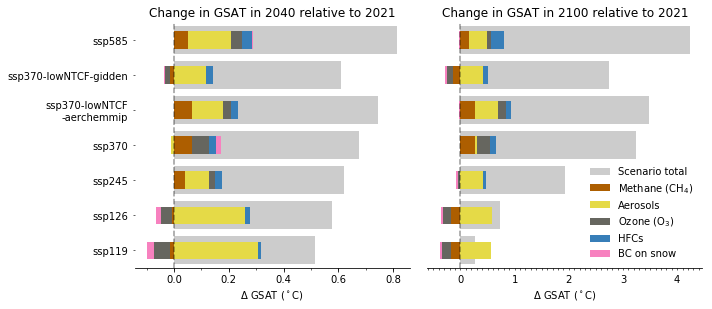

In [87]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)

fig, axs = plt.subplots(1, len(years), figsize=[10, 4.4], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    # Pick out year and do various renames:
    # Total antropogenic
    tot_yr = tabel_dT_anthrop.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Sum SLCFs
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Plot bars for anthropopogenic total:
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            )
    # Plot bars for SLCFs total:
    ntot = 'Sum SLCFs'
    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values

    # Plot stacked plot of components:
    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, color=ls, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend(frameon=False, ncol=1)  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    # Zero line:
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    # ax.grid(axis='y', which='major')

ax = axs[0]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(right=False, left=False)  # , color='w')

ax = axs[1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelleft=False, right=False, left=False, color='w')
ax.tick_params(labelright=False, labelleft=False, right=False, left=False, color='w')
ax.yaxis.set_visible(False)
plt.tight_layout()

fn = RESULTS_DIR / 'figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

plt.savefig(fn, dpi=300)

In [88]:
scen_no_lowNTCF = [scn for scn in scenarios_fl if 'lowNTCF' not in scn]
print(scen_no_lowNTCF)

['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']


In [89]:
tabel_dT_anthrop2= tabel_dT_anthrop[scen_no_lowNTCF]
tabel_dT_slcfs2= tabel_dT_slcfs[scen_no_lowNTCF]

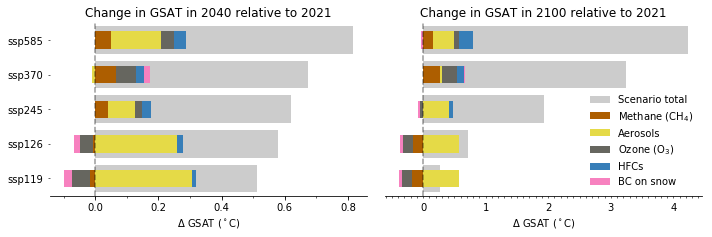

In [90]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)

fig, axs = plt.subplots(1, len(years), figsize=[10, 3.4], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    # Pick out year and do various renames:
    # Total antropogenic
    tot_yr = tabel_dT_anthrop2.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Sum SLCFs
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Plot bars for anthropopogenic total:
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            )
    # Plot bars for SLCFs total:
    ntot = 'Sum SLCFs'
    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values

    # Plot stacked plot of components:
    _tab = tabel_dT_slcfs2.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, color=ls, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend(frameon=False, ncol=1)  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    # Zero line:
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    # ax.grid(axis='y', which='major')

ax = axs[0]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(right=False, left=False)  # , color='w')

ax = axs[1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelleft=False, right=False, left=False, color='w')
ax.tick_params(labelright=False, labelleft=False, right=False, left=False, color='w')
ax.yaxis.set_visible(False)
plt.tight_layout()

fn = RESULTS_DIR / 'figures/stack_bar_influence_years_no_lowNTCF.png'
plt.tight_layout()
ax = plt.gca()

plt.savefig(fn, dpi=300)

In [91]:
tabel_dT_slcfs

ssp119      ssp126      ssp245      ssp370  \
                                                                         
2040 Methane (CH$_4$)   -0.0164059 -0.00853214   0.0388736    0.064004   
     Aerosols             0.307376     0.25748   0.0872585 -0.00967124   
     Ozone (O$_3$)      -0.0568928  -0.0384577   0.0225677   0.0652059   
     HFCs                0.0108837   0.0197257   0.0275604   0.0254467   
     BC on snow         -0.0242442  -0.0202685 -0.00193313    0.017046   
2100 Methane (CH$_4$)    -0.176115    -0.16605  -0.0063659    0.271785   
     Aerosols             0.567242    0.575669    0.409992   0.0367205   
     Ozone (O$_3$)       -0.156076   -0.152359  -0.0437196    0.239299   
     HFCs             -0.000460781  0.00235895   0.0638183    0.102139   
     BC on snow         -0.0472427  -0.0442687   -0.039955   0.0116185   

                      ssp370-lowNTCF-aerchemmip ssp370-lowNTCF-gidden  \
                                                                        
2040 Methane (CH$_4$)                  0.064004            -0.0152726   
     Aerosols                          0.115718              0.115718   
     Ozone (O$_3$)                     0.029017            -0.0197647   
     HFCs                             0.0254467             0.0255205   
     BC on snow                    -0.000667837          -0.000667837   
2100 Methane (CH$_4$)                  0.271785              -0.14287   
     Aerosols                          0.411759              0.411759   
     Ozone (O$_3$)                     0.155982             -0.107453   
     HFCs                              0.102139             0.0894802   
     BC on snow                      -0.0318657            -0.0318657   

                           ssp585  
                                   
2040 Methane (CH$_4$)   0.0510205  
     Aerosols            0.158498  
     Ozone (O$_3$)       0.039109  
     HFCs               0.0369336  
     BC on snow        0.00128484  
2100 Methane (CH$_4$)    0.158296  
     Aerosols            0.335527  
     Ozone (O$_3$)      0.0726126  
     HFCs                0.231585  
     BC on snow        -0.0313247

## Error bars from model uncertainty AND ECS uncertainty

See [Uncertainty_calculation.ipynb](Uncertainty_calculation.ipynb)

## Only ssp370:

In [92]:
scenario_370 = [sc for sc in scenarios_fl if 'ssp370' in sc]

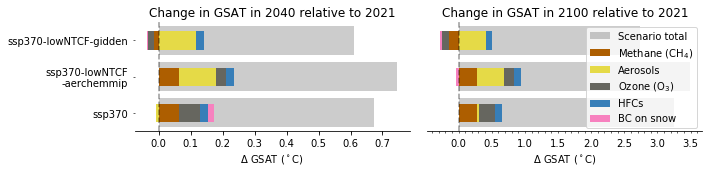

In [93]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[10, 2.5], sharex=False, sharey=True)

tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    # Pick out year and do various renames:
    # Total antropogenic
    tot_yr = tabel_dT_anthrop.loc[yr, scenario_370].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Sum SLCFs
    sum_yr = tabel_dT_sum_slcf.loc[yr, scenario_370].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Plot bars for anthropopogenic total:
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            )
    # Plot bars for SLCFs total:
    ntot = 'Sum SLCFs'
    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values

    # Plot stacked plot of components:
    _tab = tabel_dT_slcfs.loc[yr, scenario_370].transpose().rename(
        {'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, color=ls,
                  legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend(frameon=True, )  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    # Zero line:
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    # ax.grid(axis='y', which='major')

ax = axs[0]

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(right=False, left=False)  # , color='w')

ax = axs[1]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelleft=False, right=False, left=False, color='w')
ax.tick_params(labelright=False, labelleft=False, right=False, left=False, color='w')
ax.yaxis.set_visible(False)
plt.tight_layout()
fn = RESULTS_DIR / 'figures/stack_bar_influence_years_horiz_errTot_370only.png'

plt.tight_layout()
ax = plt.gca()

plt.savefig(fn, dpi=300)